# Flower Species Classification with Deep Learning: A Predictive Approach
Welcome to AI, this notebook routes you through building a deep learning model for classify flower species. Where we would be learning how to get data from kaggle competetion to Google colab, training a keras neural network, model evaluation etc.

In this notebook we would comparing the performance of various models, hyperparameter tuning and plotting performance graphs.The data used in this notebook is available in Kaggle.



## Getting data from Kaggle

Follow this link to get data from Kaggle
https://www.kaggle.com/discussions/general/74235<br>

In [ ]:
#Kaggle
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c tpu-getting-started
# ! unzip  /content/tpu-getting-started.zip   -d /content/Data

In [ ]:
# %cd /content/drive/MyDrive/
# %cp -av /content/Data/tfrecords-jpeg-192x192 tfrecords-jpeg-192x192

## About the data
Data for this notebook is taken from Kaggle. It consits data in tfrecords format and images of sizes 192x192 , 224x224, 331x331 and 512x512.<br>

Data<br>
 |-- tfrecords-jpeg-192x192<br>
 |-- tfrecords-jpeg-224x224<br>
 |-- tfrecords-jpeg-331x331<br>
 |-- tfrecords-jpeg-512x512<br>


I have choosen 192x192 for my model training and testing and uploaded the data to my google drive for easy accesss.
Follow this link to know how to upload data to google drive. https://medium.com/analytics-vidhya/a-simple-way-to-copy-entire-folders-in-google-drive-7eabd5426049

In [2]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


## Loading Data
The data is available in tf.records format. To load the TFrecords data , please refer the below link.<br>
https://www.kaggle.com/code/ryanholbrook/exercise-create-your-first-submission/notebook

In [4]:
GCS_DS_PATH = "/content/drive/MyDrive/"
BATCH_SIZE = 32
IMAGE_SIZE = [192, 192]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-192x192'
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [5]:
TRAINING_FILENAMES

['/content/drive/MyDrive//tfrecords-jpeg-192x192/train/00-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/01-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/02-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/04-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/03-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/05-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/06-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/07-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/08-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/09-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/10-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/11-192x192-798.tfrec',
 '/content/drive/MyDrive//tfrecords-jpeg-192x192/train/12-192x19

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [18]:
#Performing data Augumentation
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.9)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return image, label

In [19]:


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [20]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [21]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Training data label examples: [ 4  4 62 ...  4 73 13]


In [22]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
(16, 192, 192, 3) (16,)
Test data IDs: ['5d23a793d' '49e871eee' '7371defc6' ... 'f4672d1aa' '64a27fd4c' '31323febb']


In [23]:
from matplotlib import pyplot as plt
import math
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [24]:
ds_iter = iter(ds_train.unbatch().batch(20))

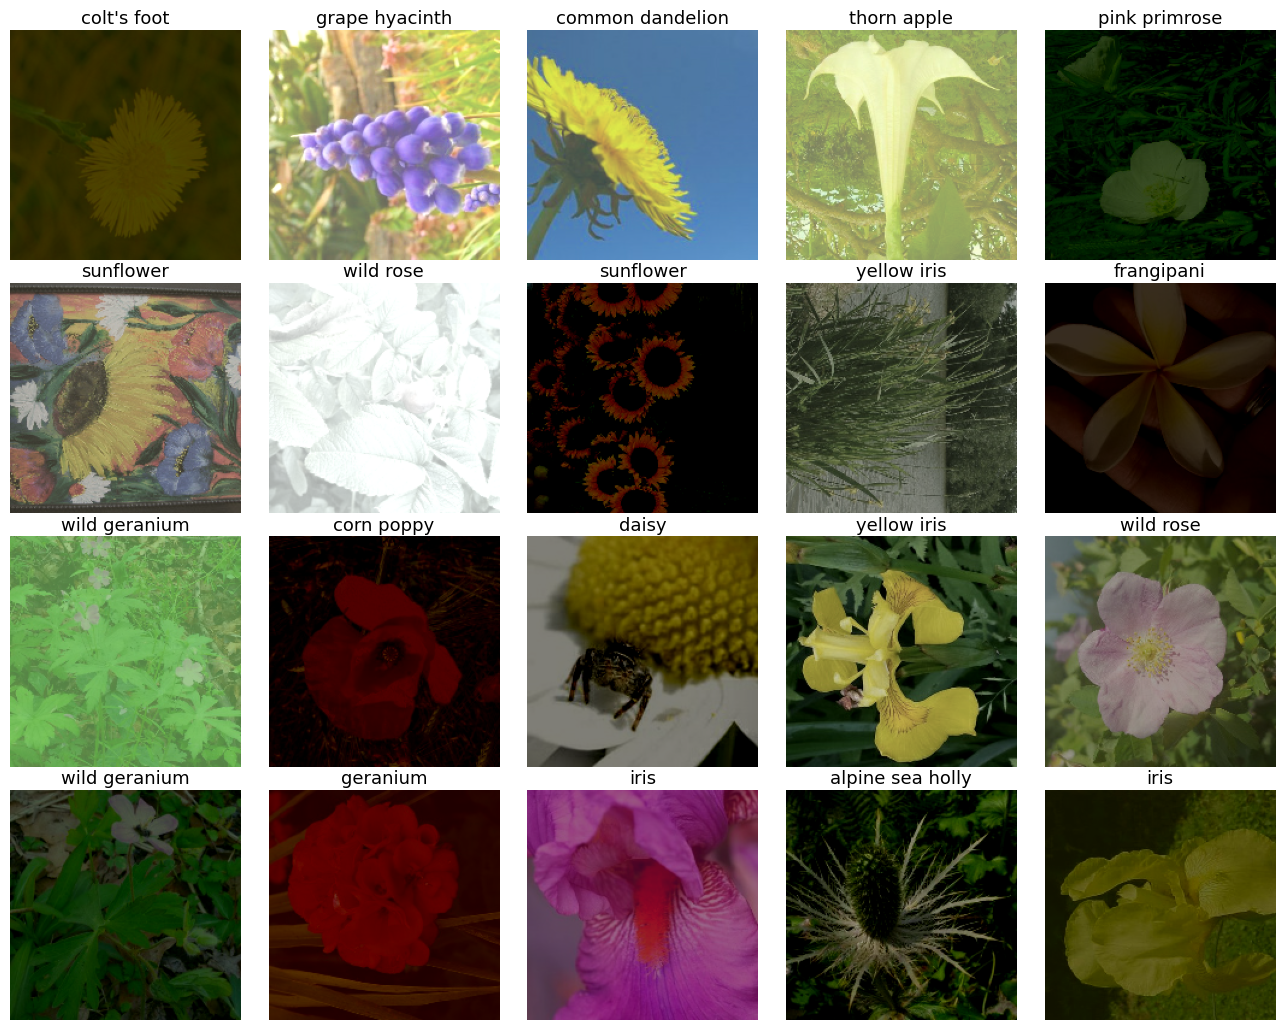

In [25]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

In [15]:
from tensorflow.keras import layers,models

In [27]:
with strategy.scope():
    # Load VGG19 as a pre-trained model
    pretrained_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False

    # Build your model
    model = tf.keras.Sequential([
        pretrained_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(len(CLASSES), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 104)               53352     
                                                                 
Total params: 20340392 (77.59 MB)
Trainable params: 316008 (1.21 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [17]:
model.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 104)               53352     
                                                                 
Total params: 20340392 (77.59 MB)
Trainable params: 316008 (1.21 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [28]:
# Define training epochs
EPOCHS = 100
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,

)

Epoch 1/100
797/797 [==============================] - 83s 85ms/step - loss: 3.7939 - accuracy: 0.1406 - val_loss: 3.0523 - val_accuracy: 0.2513
Epoch 2/100
797/797 [==============================] - 60s 76ms/step - loss: 3.2451 - accuracy: 0.2248 - val_loss: 2.6048 - val_accuracy: 0.3499
Epoch 3/100
797/797 [==============================] - 68s 85ms/step - loss: 2.9686 - accuracy: 0.2777 - val_loss: 2.3073 - val_accuracy: 0.4189
Epoch 4/100
797/797 [==============================] - 61s 76ms/step - loss: 2.7977 - accuracy: 0.3064 - val_loss: 2.2244 - val_accuracy: 0.4181
Epoch 5/100
797/797 [==============================] - 61s 76ms/step - loss: 2.7124 - accuracy: 0.3158 - val_loss: 2.1063 - val_accuracy: 0.4442
Epoch 6/100
797/797 [==============================] - 60s 76ms/step - loss: 2.6323 - accuracy: 0.3403 - val_loss: 2.0410 - val_accuracy: 0.4714
Epoch 7/100
797/797 [==============================] - 61s 76ms/step - loss: 2.5791 - accuracy: 0.3460 - val_loss: 2.0126 - val_ac

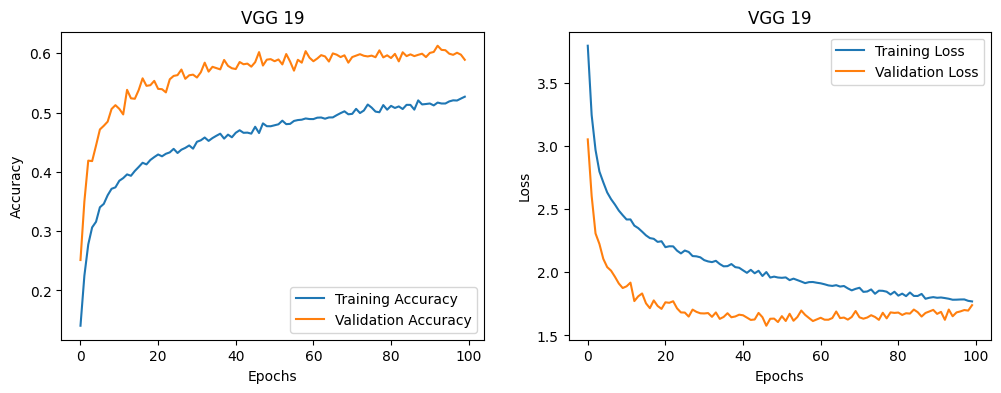

In [36]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("VGG 19")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("VGG 19")
plt.show()

In [37]:
#Valdiation accuracy

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(ds_valid)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')



232/232 [==============================] - 13s 56ms/step - loss: 1.7394 - accuracy: 0.5889
Validation Loss: 1.7394260168075562, Validation Accuracy: 0.5889008641242981


In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
y_true = []
y_pred = []

for batch in ds_valid:
    images, labels = batch
    predictions = model.predict(images)
    for y_p in predictions:
      y_pred.append(np.argmax(y_p))
    print(len(predictions[0]))
    # print(len(labels))
    y_true.extend(labels.numpy())


# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Classification Report
# class_report = classification_report(y_true, y_pred, target_names=CLASSES)
# print("Classification Report:\n", class_report)







1/1 [==============================] - 0s 37ms/step
104
1/1 [==============================] - 0s 64ms/step
104
1/1 [==============================] - 0s 75ms/step
104
1/1 [==============================] - 0s 90ms/step
104
1/1 [==============================] - 0s 54ms/step
104
1/1 [==============================] - 0s 75ms/step
104
1/1 [==============================] - 0s 78ms/step
104
1/1 [==============================] - 0s 74ms/step
104
1/1 [==============================] - 0s 81ms/step
104
1/1 [==============================] - 0s 83ms/step
104
1/1 [==============================] - 0s 94ms/step
104
1/1 [==============================] - 0s 97ms/step
104
1/1 [==============================] - 0s 52ms/step
104
1/1 [==============================] - 0s 67ms/step
104
1/1 [==============================] - 0s 42ms/step
104
1/1 [==============================] - 0s 35ms/step
104
1/1 [==============================] - 0s 35ms/step
104
1/1 [==============================] - 0s 73ms/s

In [52]:
len(y_pred)

3712

In [53]:
len(y_true)

3712

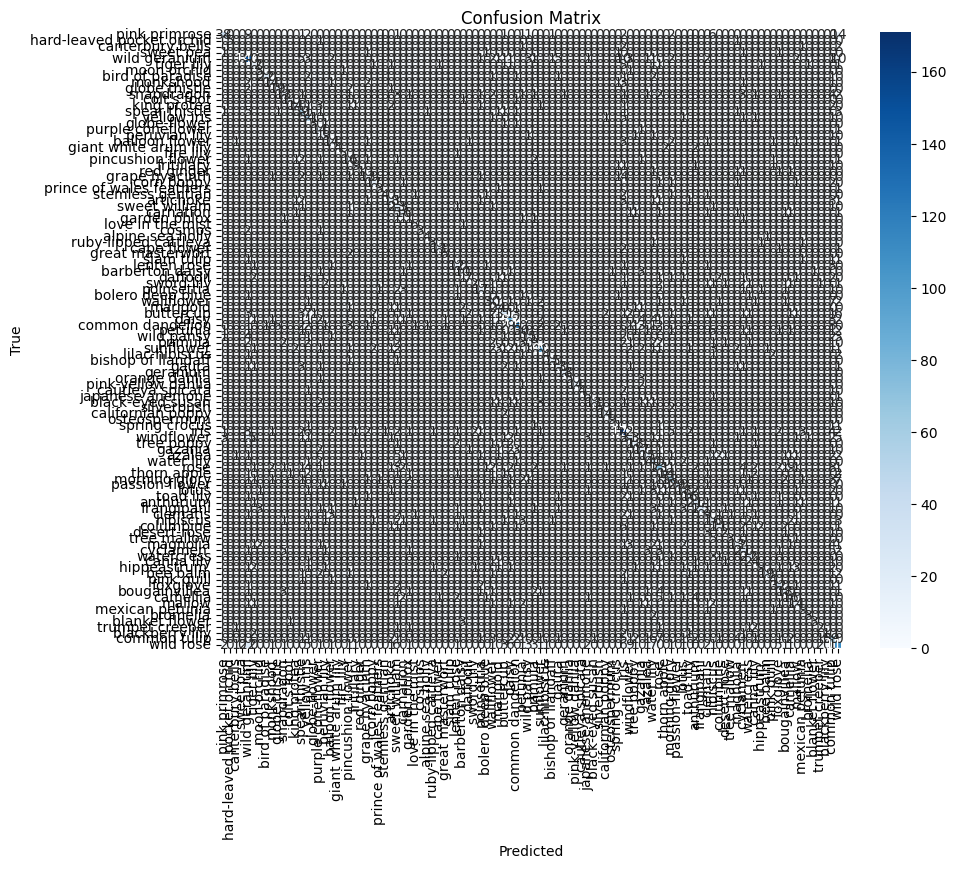

Classification Report:
                            precision    recall  f1-score   support

            pink primrose       0.79      0.48      0.60        79
hard-leaved pocket orchid       1.00      0.71      0.83         7
         canterbury bells       0.00      0.00      0.00         6
                sweet pea       0.00      0.00      0.00         6
            wild geranium       0.61      0.71      0.66       205
               tiger lily       0.44      0.48      0.46        25
              moon orchid       0.33      0.60      0.43         5
         bird of paradise       0.96      0.71      0.81        31
                monkshood       0.67      0.56      0.61        25
            globe thistle       0.73      0.79      0.76        24
               snapdragon       0.48      0.33      0.39        40
              colt's foot       0.85      0.85      0.85        13
              king protea       0.74      0.52      0.61        27
            spear thistle       0.65 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=CLASSES)
print("Classification Report:\n", class_report)
